In [1]:
import torch
import torch.optim as optim
import numpy as np


# Visualising Rastrigin function

Consider the 2D Rastrigin function (https://en.wikipedia.org/wiki/Rastrigin_function) with A = 1.0 (the default A = 10 gives an extremely bumpy loss surface; smaller values are much less perturbed). Starting at [5,5] compute the point where the following optimisers arrive at after 100 iterations:

- SGD (lr=0.01)

- SGD+Momentum (lr=0.01, momentum=0.9) 

- Adagrad (lr=0.01)

- Adam (lr=0.01)

Create a loss plot showing the function value at each iteration for each of the different optimisers. Use the PyTorch implementations of the optimisers with the default values for unspecified parameters. Which optimiser works best?

In [5]:
def rastrigin2D(x_y, A=1.0):
    x, y = x_y
    A = torch.tensor(A)
    return A*2 + (x**2 - A*torch.cos(2*np.pi*x)) + (y**2 - A*torch.cos(2*np.pi*y))


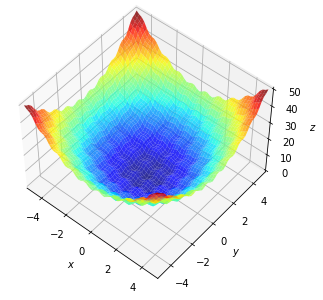

In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

xmin, xmax, xstep = -5, 5, .2
ymin, ymax, ystep = -5, 5, .2
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

z = rastrigin2D(torch.tensor([x, y]), 1.0).numpy()

fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)
ax.plot_surface(x, y, z, rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

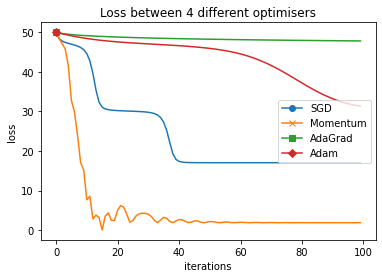

In [10]:

optimizers = {}
optimizers['SGD'] = lambda p: optim.SGD([p], lr=0.01)
optimizers['Momentum'] = lambda p: optim.SGD([p], lr=0.01, momentum=0.9)
optimizers['AdaGrad'] = lambda p: optim.Adagrad([p], lr=0.01)
optimizers['Adam'] = lambda p: optim.Adam([p], lr=0.01)

iters_num = 100
train_loss={}
for key in optimizers.keys():
    p = torch.tensor([[5.0],[5.0]], requires_grad=True)
    opt = optimizers[key](p)
    train_loss[key] = []

    for i in range(iters_num):
        opt.zero_grad()
        loss = rastrigin2D(p)
        loss.backward()
        train_loss[key].append(loss.data)
        opt.step()

markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
for key in optimizers.keys():
    plt.plot(np.arange(iters_num), train_loss[key], marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title('Loss between 4 different optimisers')
plt.legend()
plt.show()


# Iris SVM

Use the following optimisers to train Soft-margin Linear SVMs (using the code from the lab notebook) with a weight decay of 0.0001 on the training data:

- SGD (lr=0.01)

- Adam (lr=0.01)

Use a batch size of 25 and train for 100 epochs.

What is the validation accuracy for the two different models? Do you notice anything counter-intuitive in expectation over random initialisations?
 

In [14]:
import torch
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
df = df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

df = df.sample(frac=1, random_state=0) #shuffle


In [4]:
df = df[df[4].isin(['Iris-virginica', 'Iris-versicolor'])] #filter
df.head()


,0,1,2,3,4
114,5.8,2.8,5.1,2.4,Iris-virginica
62,6.0,2.2,4.0,1.0,Iris-versicolor
107,7.3,2.9,6.3,1.8,Iris-virginica
100,6.3,3.3,6.0,2.5,Iris-virginica
86,6.7,3.1,4.7,1.5,Iris-versicolor


In [5]:
mapping = {k: v for v, k in enumerate(df[4].unique())} 

mapping



{'Iris-virginica': 0, 'Iris-versicolor': 1}

In [6]:
df[5] = (2 * df[4].map(mapping))- 1 #labels in {−1,1}
df.head()


,0,1,2,3,4,5
114,5.8,2.8,5.1,2.4,Iris-virginica,-1
62,6.0,2.2,4.0,1.0,Iris-versicolor,1
107,7.3,2.9,6.3,1.8,Iris-virginica,-1
100,6.3,3.3,6.0,2.5,Iris-virginica,-1
86,6.7,3.1,4.7,1.5,Iris-versicolor,1


In [7]:
# normalize
alldata = torch.tensor(df.iloc[:, [0,1,2,3]].values, dtype=torch.float) 

alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)


In [8]:
# create datasets
X_train = alldata[:75]
y_train = torch.tensor(df.iloc[:75, 5].values, dtype=torch.long) 

X_test = alldata[75:]
y_test = torch.tensor(df.iloc[75:, 5].values, dtype=torch.long) 


In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape


(torch.Size([75, 4]), torch.Size([75]), torch.Size([25, 4]), torch.Size([25]))

In [10]:

def hinge_loss(y_pred, y_true):
    return torch.mean(torch.max(torch.tensor(0.0), 1 - y_pred * y_true))

def svm(x, w, b):
    h = (w*x).sum(1) + b
    return h


In [11]:
from torch.utils.data import TensorDataset, DataLoader

training_set = TensorDataset(X_train, y_train)
dataloader = DataLoader(training_set, batch_size=25, shuffle=True)


In [ ]:
test_acc = []
iters=20
for i in range(iters):
    # initialize parameter
    w = torch.randn(1, X_train.shape[1], requires_grad=True)
    b = torch.randn(1, requires_grad=True)

    opt = optim.SGD([w, b], lr=0.01, weight_decay=0.0001)

    for epoch in range(100):
        for batch in dataloader:
            opt.zero_grad()
            output = hinge_loss(svm(batch[0], w, b), batch[1])
            output.backward()
            opt.step()

    y_hat = torch.where(svm(X_test, w, b) >= 1, 1, -1)
    test_acc.append(torch.sum(y_hat == y_test) /len(y_test))

plt.plot(test_acc, label='test acc')
plt.legend()
plt.xticks(np.arange(0, iters, step=2))
plt.show()

test_acc, np.mean(test_acc)


In [ ]:
test_acc = []
iters=20
for i in range(iters):
    # initialize parameter
    w_a = torch.randn(1, X_train.shape[1], requires_grad=True)
    b_a = torch.randn(1, requires_grad=True)

    opt_adam = optim.Adam([w_a, b_a], lr=0.01, weight_decay=0.0001)
    for epoch in range(100):
        for batch in dataloader:
            opt_adam.zero_grad()
            loss = hinge_loss(svm(batch[0], w_a, b_a), batch[1])
            loss.backward()
            opt_adam.step()

    y_hat = torch.where(svm(X_test, w_a, b_a) >= 1, 1, -1)
    test_acc.append(torch.sum(y_hat == y_test) /len(y_test))

plt.plot(test_acc, label='test acc')
plt.legend()
plt.xticks(np.arange(0, iters, step=2))
plt.show()

test_acc, np.mean(test_acc)
